In [90]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import requests
import json
import requests
import time
from datetime import datetime
from IPython.display import display, clear_output
import numpy as np
import seaborn as sns

In [91]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [92]:
target_diff = 0.0025
stop_loss = 0.0025
profit = (target_diff / 0.0001)*0.75
loss = (stop_loss / 0.0001)*0.75
version = '10'

In [93]:
filename_date = '100919'

layout = pd.read_csv('../data/' + filename_date + 'mds_out_layout.csv')
layout = layout['features'].values
data = pd.read_csv('../data/' + filename_date + 'mds_out.csv', usecols=layout)
data.shape

(16415, 785)

In [94]:
data['time'].min()

'2017-01-19 21:00:00'

In [95]:
data['time'].max()

'2019-09-24 19:00:00'

In [96]:
num_cols = ['ask_c', 'bid_c']

In [97]:
data['time'] = pd.to_datetime(data['time'])
data = data.sort_values(by='time')
data = data.drop_duplicates(subset=['time'])
data = data.reset_index(drop=True)
data['index'] = data.index
for n in num_cols:
    data[n] = pd.to_numeric(data[n])
data['target_sl'] = data['ask_c'] + stop_loss
data['target_tp'] = data['bid_c'] - target_diff
data = data[~data['target_tp'].isnull()]

In [98]:
data['diff'] = data['target_tp'] - data['target_sl']
data['diff'].describe()

count    16415.000000
mean        -0.005155
std          0.000097
min         -0.006500
25%         -0.005140
50%         -0.005130
75%         -0.005120
max         -0.005090
Name: diff, dtype: float64

In [99]:
# data[['index', 'time', 'volume', 'bid_o', 'bid_h','bid_l','bid_c', 'ask_o', 'ask_h','ask_l','ask_c', 'ask_prev_c', 'bid_prev_c', 'target_tp', 'target_sl', 'g', 'l', 'l_time']].head(40)

In [100]:
data['g']=np.NaN
data['l']=np.NaN
deep=len(data.index)
irange = data['index'].values
tp_good = False
sl_good = False

for i in irange:

    while tp_good == False and sl_good == False:
        show = (i / len(irange))*100
        show = str(round(show, 2))
        show = show + ' - ' + str(datetime.now())
        display(show)
        tp_good = False
        sl_good = False
    #     print(i)

        for r in irange:
    #             print(i, r, tp_good, sl_good)
            if r > i:
                if tp_good == False and sl_good == False:
                    if  data[data['index'] == r]['ask_h'].values[0] >= data[data['index'] == i]['target_sl'].values[0] and not tp_good:
                        data.at[i, 'g'] = data[data['index'] == r]['index'].values[0]
                        data.at[i, 'g_time'] = data[data['index'] == r]['time'].values[0]
                        tp_good = True
                    else:
                        data.at[i, 'g'] = None
                        data.at[i, 'g_time'] =None

                    if  data[data['index'] == r]['bid_l'].values[0] <= data[data['index'] == i]['target_tp'].values[0] and not sl_good:
                        data.at[i, 'l'] = data[data['index'] == r]['index'].values[0]
                        data.at[i, 'l_time'] = data[data['index'] == r]['time'].values[0]
                        sl_good = True
                    else:  
                        data.at[i, 'l'] = None     
                        data.at[i, 'l_time'] = None  
                else:
                    break

        clear_output()    

#     print(datetime.now())

In [101]:
# START WITH FIRST TARGET INDEX BEC TIME ISSUE

if tp_good:
    target_index = data['g'].max()
    good_data = data[~data['g'].isnull()].copy()

if sl_good:
    target_index = data['l'].max()
    good_data = data[~data['g'].isnull()].copy()

tp_good = False
sl_good = False
done = False

counter = 1
while not done:
    show = (target_index / len(irange))*100
    show = str(round(show, 2))
    show = show + ' - ' + str(datetime.now())
    display(show)
    tp_good = False
    sl_good = False

    for r in irange:
        if r > target_index:
            if tp_good == False and sl_good == False:
                if  data[data['index'] == r]['ask_h'].values[0] >= data[data['index'] == target_index]['target_sl'].values[0] and not tp_good:
                    data.at[target_index, 'g'] = data[data['index'] == r]['index'].values[0]
                    data.at[target_index, 'g_time'] = data[data['index'] == r]['time'].values[0]
                    tp_good = True
                else:
                    data.at[target_index, 'g'] = None
                    data.at[target_index, 'g_time'] =None


                if  data[data['index'] == r]['bid_l'].values[0] <= data[data['index'] == target_index]['target_tp'].values[0] and not sl_good:
                    data.at[target_index, 'l'] = data[data['index'] == r]['index'].values[0]
                    data.at[target_index, 'l_time'] = data[data['index'] == r]['time'].values[0]
                    sl_good = True

                else:  
                    data.at[i, 'l'] = None     
                    data.at[i, 'l_time'] = None  
            else:
                break
    
    if tp_good == True:
        target_index = data['g'].max()
        try:
            temp = data[data['g'] == target_index].copy()
            temp2 = data[data['index'] == target_index].copy()

            if counter == 1:
                good_data = temp
                counter += 1
            else:
                good_data = good_data.append(temp)

            if target_index == data['index'].max():
                done = True
        except IndexError:
            done = True

    elif sl_good == True:
        target_index = data['l'].max()
        try:
            temp = data[data['l'] == target_index].copy()
            temp2 = data[data['index'] == target_index].copy()

            if counter == 1:
                good_data = temp
                counter += 1
            else:
                good_data = good_data.append(temp)

            if target_index == data['index'].max():
                done = True
        except IndexError:
            done = True
            
    else:
        done = True


    clear_output()    

In [102]:
# good_mask = (data['g'].isnull()) & (data['l'].isnull())
# good_data = data[~good_mask].copy()
good_data.shape

(2012, 793)

In [103]:
good_data[['time', 'volume', 'bid_o', 'bid_h','bid_l','bid_c', 'ask_o', 'ask_h','ask_l','ask_c', 'target_tp', 'target_sl', 'g', 'l', 'l_time']].head(10)

,time,volume,bid_o,bid_h,bid_l,bid_c,ask_o,ask_h,ask_l,ask_c,target_tp,target_sl,g,l,l_time
1,2017-01-19 22:00:00,2878,1.06528,1.06871,1.06528,1.06808,1.06545,1.06888,1.06545,1.06821,1.06558,1.07071,NaN,9.0,2017-01-20 06:00:00
9,2017-01-20 06:00:00,5923,1.06627,1.06665,1.06416,1.06459,1.06638,1.06678,1.06428,1.06470,1.06209,1.06720,15.0,NaN,NaT
15,2017-01-20 12:00:00,8486,1.06545,1.06830,1.06543,1.06783,1.06557,1.06842,1.06555,1.06794,1.06533,1.07044,19.0,NaN,NaT
19,2017-01-20 16:00:00,5856,1.06806,1.07087,1.06797,1.07043,1.06820,1.07103,1.06811,1.07062,1.06793,1.07312,25.0,NaN,NaT
25,2017-01-22 22:00:00,4455,1.07233,1.07442,1.07206,1.07436,1.07247,1.07458,1.07222,1.07449,1.07186,1.07699,NaN,37.0,2017-01-23 10:00:00
37,2017-01-23 10:00:00,16754,1.07338,1.07373,1.07087,1.07297,1.07353,1.07386,1.07101,1.07308,1.07047,1.07558,45.0,NaN,NaT
45,2017-01-23 18:00:00,1123,1.07427,1.07682,1.07423,1.07621,1.07443,1.07707,1.07436,1.07657,1.07371,1.07907,NaN,54.0,2017-01-24 03:00:00
54,2017-01-24 03:00:00,6523,1.07544,1.07563,1.07368,1.07405,1.07559,1.07578,1.07385,1.07419,1.07155,1.07669,62.0,NaN,NaT
62,2017-01-24 11:00:00,10717,1.07469,1.07659,1.07428,1.07602,1.07480,1.07673,1.07439,1.07625,1.07352,1.07875,NaN,66.0,2017-01-24 15:00:00
66,2017-01-24 15:00:00,3592,1.07560,1.07577,1.07330,1.07342,1.07575,1.07590,1.07344,1.07355,1.07092,1.07605,84.0,NaN,NaT


In [104]:
def get_target(value):
    if value > 0:
        return 1
    else:
        return 0

In [105]:
# max_date = data['time'].max()
good_data['g_time'] = pd.to_datetime(good_data['g_time'])
good_data['l_time'] = pd.to_datetime(good_data['l_time'])

good_data['g'] = pd.to_numeric(good_data['g'])
good_data['l'] = pd.to_numeric(good_data['l'])

good_data['g'] = good_data['g'].fillna(0)
good_data['l'] = good_data['l'].fillna(0)

# data['g'] = data['g'].fillna(data['index'].max())
# data['l'] = data['l'].fillna(data['index'].max())

good_data['long_target'] = good_data['g'].apply(get_target)
good_data['short_target'] = good_data['l'].apply(get_target)

print(good_data['long_target'].value_counts())
print()
print(good_data['short_target'].value_counts())

1    1012
0    1000
Name: long_target, dtype: int64

1    1016
0     996
Name: short_target, dtype: int64


In [106]:
# good_data['g_time_shift'] = good_data['g_time'].shift(1)
# good_data['g_time_shift'] = pd.to_datetime(good_data['g_time_shift'] )
good_data['time'] = pd.to_datetime(good_data['time'] )
# good_data['g_diff'] = good_data['g_time'] - good_data['g_time_shift']
# good_data['g_diff'] = good_data['g_diff'].dt.seconds

In [107]:
# good_data['order'] = good_data.index
# t1 = good_data[good_data['g'] != 0.0].drop_duplicates(subset='g')
# t2 = good_data[good_data['l'] != 0.0].drop_duplicates(subset='l')
# good_data = pd.concat([t1, t2], axis=0)
# good_data= good_data.sort_values(by='order')
good_data['same_time'] = good_data['g_time'] == good_data['l_time']
good_data['same_time'] = good_data['same_time'].apply(lambda x: 1 if x else 0)
good_data = good_data[good_data['same_time'] == 0]
good_data.shape

(1996, 796)

In [108]:
pos = good_data[good_data['short_target'] == 1].copy()
print(pos.shape)
neg = good_data[good_data['short_target'] == 0].copy()

pos['time_diff'] = (pos['l_time'] - pos['time']) / np.timedelta64(1, 'h')

pos_bad = pos[pos['time_diff'] > 24].copy()
pos_bad['short_target'] = 0

pos = pos[pos['time_diff'] <= 24]

pos.drop(['time_diff'], axis=1, inplace=True)
pos_bad.drop(['time_diff'], axis=1, inplace=True)

good_data = pd.concat([pos, neg, pos_bad], axis=0)
good_data.shape

(1000, 796)


(1996, 796)

In [109]:
good_data['short_target'].value_counts()

0    1077
1     919
Name: short_target, dtype: int64

In [110]:
good_data.to_csv('../data/' + filename_date + '_mds_out_final_v' + version + '_short_live.csv', index=False, header=True)

In [111]:
good_data[['time', 'bid_c', 'ask_c','target_tp', 'target_sl', 'g', 'l', 'g_time', 'l_time', 'long_target', 'short_target', 'time']].head(10)

,time,bid_c,ask_c,target_tp,target_sl,g,l,g_time,l_time,long_target,short_target,time
1,2017-01-19 22:00:00,1.06808,1.06821,1.06558,1.07071,0.0,9.0,NaT,2017-01-20 06:00:00,0,1,2017-01-19 22:00:00
25,2017-01-22 22:00:00,1.07436,1.07449,1.07186,1.07699,0.0,37.0,NaT,2017-01-23 10:00:00,0,1,2017-01-22 22:00:00
45,2017-01-23 18:00:00,1.07621,1.07657,1.07371,1.07907,0.0,54.0,NaT,2017-01-24 03:00:00,0,1,2017-01-23 18:00:00
62,2017-01-24 11:00:00,1.07602,1.07625,1.07352,1.07875,0.0,66.0,NaT,2017-01-24 15:00:00,0,1,2017-01-24 11:00:00
84,2017-01-25 09:00:00,1.07451,1.07462,1.07201,1.07712,0.0,86.0,NaT,2017-01-25 11:00:00,0,1,2017-01-25 09:00:00
88,2017-01-25 13:00:00,1.07424,1.07436,1.07174,1.07686,0.0,105.0,NaT,2017-01-26 06:00:00,0,1,2017-01-25 13:00:00
105,2017-01-26 06:00:00,1.07205,1.07217,1.06955,1.07467,0.0,109.0,NaT,2017-01-26 10:00:00,0,1,2017-01-26 06:00:00
109,2017-01-26 10:00:00,1.06964,1.06977,1.06714,1.07227,0.0,111.0,NaT,2017-01-26 12:00:00,0,1,2017-01-26 10:00:00
114,2017-01-26 15:00:00,1.06954,1.06967,1.06704,1.07217,0.0,117.0,NaT,2017-01-26 18:00:00,0,1,2017-01-26 15:00:00
145,2017-01-29 22:00:00,1.07360,1.07376,1.07110,1.07626,0.0,151.0,NaT,2017-01-30 04:00:00,0,1,2017-01-29 22:00:00


In [112]:
shorts = good_data[good_data['short_target'] == 1].copy()
shorts['time'] = pd.to_datetime(shorts['time'])
shorts['l_time'] = pd.to_datetime(shorts['l_time'] )
shorts['time_diff'] = shorts['l_time'] - shorts['time']
shorts['time_diff'].head() 

1    08:00:00
25   12:00:00
45   09:00:00
62   04:00:00
84   02:00:00
Name: time_diff, dtype: timedelta64[ns]

In [113]:
shorts['time_diff'] = shorts['time_diff']  / np.timedelta64(1, 'h')

In [114]:
shorts['time_diff'].describe()

count    919.000000
mean       6.825898
std        6.245708
min        1.000000
25%        2.000000
50%        4.000000
75%       10.000000
max       24.000000
Name: time_diff, dtype: float64

In [115]:
dcounts = good_data['time'].value_counts().reset_index()
dcounts.columns = ['time', 'count']

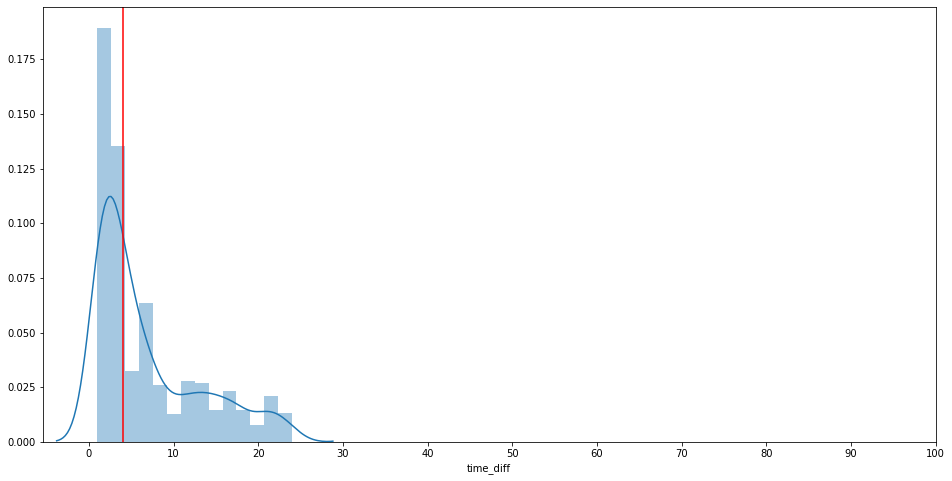

In [116]:
fig, ax = plt.subplots(figsize=(16,8))
sns.distplot(shorts['time_diff'])
ax.set_xticks(np.arange(0, 110, 10))
ax.axvline(x=4, color='red')

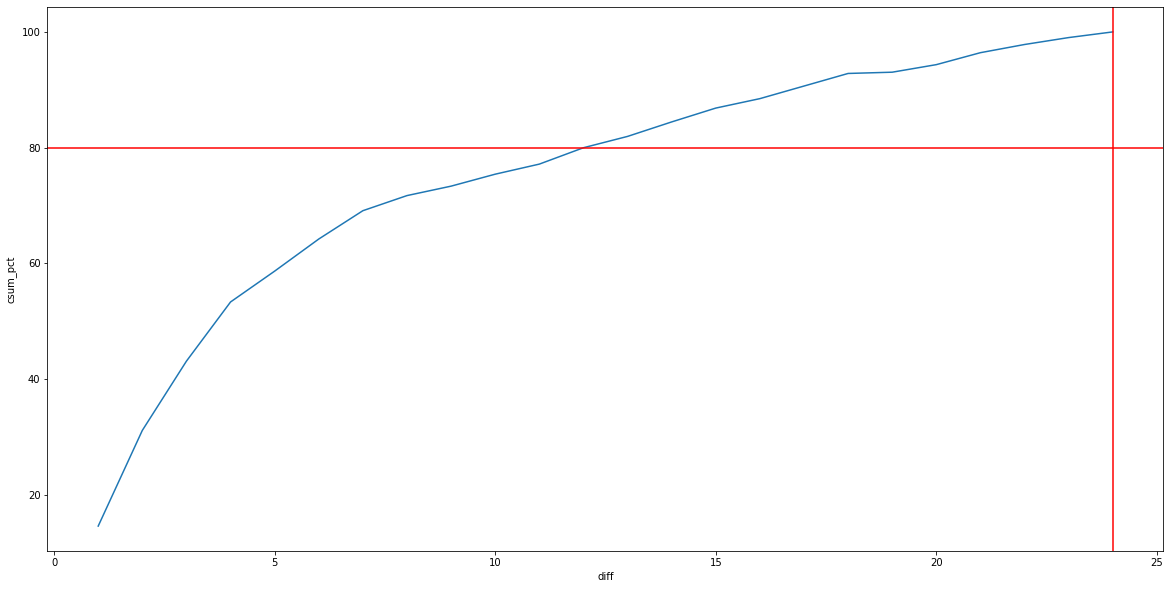

In [117]:
tcnt = shorts['time_diff'].value_counts().reset_index()
tcnt.columns = ['diff', 'count']
tcnt = tcnt.sort_values(by='diff')
tcnt['csum'] = tcnt['count'].cumsum()
tcnt['csum_pct'] = (tcnt['csum'] / tcnt['count'].sum()) * 100
tcnt['count_pct'] = (tcnt['count'] / tcnt['count'].sum()) * 100
tcnt['count_pct_ra']  = tcnt['count_pct'].rolling(8, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x='diff', y='csum_pct', data=tcnt)
ax.axhline(y=80, color='red')
ax.axvline(x=24, color='red')

In [118]:
shorts['time_diff'].max()

24.0

In [119]:
tcnt

,diff,count,csum,csum_pct,count_pct,count_pct_ra
1,1.0,134,134,14.581066,14.581066,14.581066
0,2.0,152,286,31.120783,16.539717,15.560392
2,3.0,110,396,43.090316,11.969532,14.363439
3,4.0,94,490,53.318825,10.228509,13.329706
5,5.0,49,539,58.650707,5.331882,11.730141
4,6.0,51,590,64.200218,5.549510,10.700036
6,7.0,45,635,69.096844,4.896627,9.870978
8,8.0,24,659,71.708379,2.611534,8.963547
18,9.0,15,674,73.340588,1.632209,7.344940
13,10.0,19,693,75.408052,2.067465,5.535909
